In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
import statsmodels.api as sm


In [ ]:
RAW_FILE  = Path("./processed/quarterly_features.csv")  # change to your actual path if needed
PROC_DIR  = Path("./processed"); PROC_DIR.mkdir(exist_ok=True)

def inspect_csv(path: Path, n=5):
    df = pd.read_csv(path)
    print("Columns:", list(df.columns))
    print("Shape:", df.shape)
    print(df.head(n).to_string(index=False))
    # show a couple of likely date-ish columns if present
    for c in df.columns:
        if any(k in c.lower() for k in ("date", "quarter", "__q", "period")):
            print(f"\nSample values from '{c}':")
            print(df[c].head(10).tolist())
    return df

def _parse_quarter_series(s: pd.Series) -> pd.DatetimeIndex:
    """Parse strings like '2012-Q1', '2012.0-Q1', '2012Q1', or real dates to quarter-end."""
    s = s.astype(str).str.strip()
    s = (s
         .str.replace(r"\.0", "", regex=True)
         .str.replace(r"(?i)q", "Q", regex=True)
         .str.replace(r"(?i)^(\d{4})\s*[-/]?\s*Q([1-4])$", r"\1-Q\2", regex=True))
    # Try 'PeriodIndex' (quarters)
    try:
        pi = pd.PeriodIndex(s, freq="Q")
        return pi.to_timestamp("Q")  # quarter-end
    except Exception:
        pass
    # Fallback to normal datetime
    dt = pd.to_datetime(s, errors="coerce", dayfirst=False)
    return dt

def smart_load_features(path_csv=RAW_FILE, path_parq=PROC_DIR/"quarterly_features.parquet") -> pd.DataFrame:
    # Prefer parquet if present (types safer)
    if path_parq.exists():
        df = pd.read_parquet(path_parq)
    else:
        df = pd.read_csv(path_csv)

    # If already DatetimeIndex, standardize name
    if isinstance(df.index, pd.DatetimeIndex):
        out = df.copy()
        out.index.name = "date_q"
        return out.sort_index()

    # If first column is an unnamed index dump, try to parse it as dates/quarters
    if df.columns[0].lower().startswith("unnamed"):
        idx_try = pd.to_datetime(df.iloc[:, 0], errors="coerce")
        if idx_try.notna().mean() > 0.8:
            out = df.iloc[:, 1:].copy()
            out.index = idx_try
            out.index.name = "date_q"
            return out.sort_index()

    # Look for a date/quarter-like column
    cand = [c for c in df.columns if any(k in c.lower() for k in ("date_q","quarter","date","__q","period"))]
    if cand:
        c = cand[0]
        idx = _parse_quarter_series(df[c])
        if idx.notna().mean() > 0.8:
            out = df.drop(columns=[c]).copy()
            out.index = idx
            out.index.name = "date_q"
            return out.sort_index()

    # Last fallback: try reading with index_col=0 and coercing that index
    try:
        df2 = pd.read_csv(path_csv, index_col=0)
        ix = _parse_quarter_series(pd.Series(df2.index))
        if ix.notna().mean() > 0.8:
            df2.index = ix
            df2.index.name = "date_q"
            return df2.sort_index()
    except Exception:
        pass

    raise ValueError("Could not find/parse a date/quarter column. Check your CSV headers & content.")

# --- Run inspection + load ---
_ = inspect_csv(RAW_FILE)
qdf = smart_load_features(RAW_FILE)
print(f"\nLoaded qdf shape={qdf.shape}, range={qdf.index.min().date()} → {qdf.index.max().date()}")

Columns: ['date_q', 'excess_ret', 'midcap_qret', 'nifty_qret', 'rain_anom', 'cpi_yoy', 'gdp_yoy', 'repo_chg_bps', 'ret_prev_q', 'rain_anom_lag', 'cpi_yoy_lag', 'gdp_yoy_lag', 'repo_chg_lag', 'excess_next_q']
Shape: (44, 14)
    date_q  excess_ret  midcap_qret  nifty_qret  rain_anom  cpi_yoy  gdp_yoy  repo_chg_bps  ret_prev_q  rain_anom_lag  cpi_yoy_lag  gdp_yoy_lag  repo_chg_lag  excess_next_q
2014-06-30    0.153161     0.288472    0.135311  69.879102 7.859486 8.023963           0.0         NaN      69.879102     8.244298     5.342980          25.0      -0.017474
2014-09-30   -0.017474     0.028963    0.046437  -7.449626 6.681568 8.704109           0.0    0.288472      69.879102     7.859486     8.023963           0.0       0.062164
2014-12-31    0.062164     0.102077    0.039913  -7.449626 4.054538 5.922736           0.0    0.028963      -7.449626     6.681568     8.704109           0.0       0.008021
2015-03-31    0.008021     0.033169    0.025149  -7.449626 5.272440 7.112080        

In [ ]:
PROC = Path("./processed"); PROC.mkdir(exist_ok=True)
RAW  = PROC / "quarterly_features.csv"
PARQ = PROC / "quarterly_features.parquet"

def _parse_quarter_series(s: pd.Series) -> pd.DatetimeIndex:
    s = s.astype(str).str.strip()
    s = (s
         .str.replace(r"\.0", "", regex=True)
         .str.replace(r"(?i)q", "Q", regex=True)
         .str.replace(r"(?i)^(\d{4})\s*[-/]?\s*Q([1-4])$", r"\1-Q\2", regex=True))
    try:
        pi = pd.PeriodIndex(s, freq="Q")
        return pi.to_timestamp("Q")
    except Exception:
        return pd.to_datetime(s, errors="coerce", dayfirst=False)

def smart_load_features(path_csv=RAW, path_parq=PARQ) -> pd.DataFrame:
    if path_parq.exists():
        df = pd.read_parquet(path_parq)
    else:
        df = pd.read_csv(path_csv)

    if isinstance(df.index, pd.DatetimeIndex):
        out = df.copy(); out.index.name = "date_q"; return out.sort_index()

    if df.columns[0].lower().startswith("unnamed"):
        idx_try = pd.to_datetime(df.iloc[:, 0], errors="coerce")
        if idx_try.notna().mean() > 0.8:
            out = df.iloc[:, 1:].copy(); out.index = idx_try; out.index.name = "date_q"; return out.sort_index()

    cand = [c for c in df.columns if any(k in c.lower() for k in ("date_q","quarter","date","__q","period"))]
    if cand:
        c = cand[0]
        idx = _parse_quarter_series(df[c])
        if idx.notna().mean() > 0.8:
            out = df.drop(columns=[c]).copy(); out.index = idx; out.index.name = "date_q"; return out.sort_index()

    # last fallback
    df2 = pd.read_csv(path_csv, index_col=0)
    ix = _parse_quarter_series(pd.Series(df2.index))
    if ix.notna().mean() > 0.8:
        df2.index = ix; df2.index.name = "date_q"; return df2.sort_index()
    raise ValueError("Could not find/parse a date/quarter column.")

# --- Step 1: load ---
qdf = smart_load_features()
print(f"Loaded qdf: {qdf.shape}, {qdf.index.min().date()} → {qdf.index.max().date()}")

# --- Step 2: normalize schema / derive missing columns ---
needed = [
    'midcap_qret','nifty_qret','excess_ret',
    'rain_anom','cpi_yoy','gdp_yoy','repo_chg_bps',
    'ret_prev_q','rain_anom_lag','cpi_yoy_lag','gdp_yoy_lag','repo_chg_lag',
    'excess_next_q'
]

created = []

# cast everything numeric where possible
for c in qdf.columns:
    qdf[c] = pd.to_numeric(qdf[c], errors='ignore')

if 'excess_ret' not in qdf.columns and {'midcap_qret','nifty_qret'}.issubset(qdf.columns):
    qdf['excess_ret'] = qdf['midcap_qret'] - qdf['nifty_qret']; created.append('excess_ret')

if 'ret_prev_q' not in qdf.columns and 'excess_ret' in qdf.columns:
    qdf['ret_prev_q'] = qdf['excess_ret'].shift(1); created.append('ret_prev_q')

for base, lag in [('rain_anom','rain_anom_lag'),
                  ('cpi_yoy','cpi_yoy_lag'),
                  ('gdp_yoy','gdp_yoy_lag'),
                  ('repo_chg_bps','repo_chg_lag')]:
    if lag not in qdf.columns and base in qdf.columns:
        qdf[lag] = qdf[base].shift(1); created.append(lag)

if 'excess_next_q' not in qdf.columns and 'excess_ret' in qdf.columns:
    qdf['excess_next_q'] = qdf['excess_ret'].shift(-1); created.append('excess_next_q')

missing_after = [c for c in needed if c not in qdf.columns]
print("Created columns:", created if created else "None")
print("Still missing:", missing_after if missing_after else "None")

usable_mask = qdf[needed].apply(pd.to_numeric, errors='coerce').notna().all(axis=1)
qdf_clean = qdf.loc[usable_mask].copy()
print("Usable rows after drops:", len(qdf_clean), "/", len(qdf))

qdf_clean.to_csv(PROC/"quarterly_features_clean.csv", index=True)
qdf_clean.to_parquet(PROC/"quarterly_features.parquet", index=True)
print("Saved:", (PROC/"quarterly_features_clean.csv").resolve(), "and", (PROC/"quarterly_features.parquet").resolve())

# Use the clean DataFrame for modeling below
qdf = qdf_clean

Loaded qdf: (43, 13), 2014-09-30 → 2025-03-31
Created columns: None
Still missing: None
Usable rows after drops: 43 / 43
Saved: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\quarterly_features_clean.csv and C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\quarterly_features.parquet


C:\Users\abpanick\AppData\Local\Temp\ipykernel_34548\1350936044.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  qdf[c] = pd.to_numeric(qdf[c], errors='ignore')


In [3]:
y = qdf["excess_next_q"].astype(float)
X_base = qdf[["ret_prev_q"]].copy()
X_en   = qdf[["ret_prev_q","rain_anom_lag","gdp_yoy_lag","cpi_yoy_lag","repo_chg_lag"]].copy()
mask   = X_en.notna().all(1) & y.notna()
X_base, X_en, y = X_base.loc[mask], X_en.loc[mask], y.loc[mask]

1) Load features & define targets

Cross-validation helpers

In [ ]:
def make_expanding_splits(n, min_train=24, test_size=2, step=1):
    min_train = max(min_train, int(round(n*0.6)))
    splits, start = [], min_train
    while start + test_size <= n:
        tr = np.arange(0, start)
        te = np.arange(start, start + test_size)
        splits.append((tr, te))
        start += step
    return splits

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_true)+np.abs(y_pred)+eps))

def cv_eval(model_maker, X, y, splits):
    y_true_all, y_pred_all = [], []
    for tr, te in splits:
        mdl = model_maker()
        mdl.fit(X.iloc[tr], y.iloc[tr])
        pred = mdl.predict(X.iloc[te])
        y_true_all.extend(y.iloc[te]); y_pred_all.extend(pred)
    y_true_all, y_pred_all = np.array(y_true_all), np.array(y_pred_all)
    return dict(
        R2   = r2_score(y_true_all, y_pred_all),
        MAE  = mean_absolute_error(y_true_all, y_pred_all),
        MAPE = mean_absolute_percentage_error(y_true_all, y_pred_all),
        SMAPE= smape(y_true_all, y_pred_all)
    )

Model factories (LightGBM with sklearn fallback)

In [ ]:
def make_baseline():
    return Pipeline([
        ("sc", StandardScaler(with_mean=True, with_std=True)),
        ("enet", ElasticNetCV(cv=3, l1_ratio=[0.1,0.5,0.9], random_state=42))
    ])

def make_lgbm():
    try:
        from lightgbm import LGBMRegressor
        return LGBMRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=3,
            subsample=0.9, colsample_bytree=0.9, random_state=42
        )
    except Exception:
        from sklearn.ensemble import GradientBoostingRegressor
        return GradientBoostingRegressor(random_state=42)

RQ1 — Baseline vs Enriched (fix: delta as full DataFrame)

In [6]:
splits = make_expanding_splits(len(y), min_train=24, test_size=2, step=1)

m_base = cv_eval(make_baseline, X_base, y, splits)
m_en   = cv_eval(make_lgbm,   X_en,   y, splits)

rq1_tbl = pd.DataFrame([m_base, m_en], index=["Baseline(ret_prev_q)", "Enriched(LightGBM)"])
delta   = rq1_tbl.subtract(rq1_tbl.loc["Baseline(ret_prev_q)"], axis="columns").rename(columns=lambda c: f"Δ{c}")
rq1_out = pd.concat([rq1_tbl, delta], axis=1)

# % MAE improvement
rq1_out["%MAE_improve"] = (rq1_tbl.loc["Baseline(ret_prev_q)","MAE"] - rq1_tbl["MAE"]) / rq1_tbl.loc["Baseline(ret_prev_q)","MAE"] * 100

display(rq1_out)
rq1_out.to_csv(PROC/"rq1_metrics.csv")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 0.007365
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

R2       MAE      MAPE     SMAPE       ΔR2  \
Baseline(ret_prev_q) -0.081090  0.041095  1.055146  1.336122  0.000000   
Enriched(LightGBM)    0.018838  0.039325  1.041893  1.323075  0.099929   

                         ΔMAE     ΔMAPE    ΔSMAPE  %MAE_improve  
Baseline(ret_prev_q)  0.00000  0.000000  0.000000      0.000000  
Enriched(LightGBM)   -0.00177 -0.013253 -0.013047      4.308196

RQ2 — “Good vs Poor rain” impact (add this cell)

In [7]:
# Define good vs poor monsoon using your lagged anomaly:
# negative anomaly = above-normal rain (good); positive = below-normal (poor)
is_good = (qdf.loc[X_en.index, "rain_anom_lag"] < 0).astype(int)
grp     = pd.DataFrame({"excess_next_q": y, "good": is_good}).dropna()

g = grp[grp.good==1]["excess_next_q"].values
p = grp[grp.good==0]["excess_next_q"].values

from scipy.stats import ttest_ind, ks_2samp
tstat, p_t  = ttest_ind(g, p, equal_var=False)
ks,   p_ks  = ks_2samp(g, p)

rq2_tbl = pd.DataFrame({
    "N_good":[len(g)], "N_poor":[len(p)],
    "mean_good":[np.mean(g)], "mean_poor":[np.mean(p)],
    "Δmean":[np.mean(g)-np.mean(p)],
    "t_pvalue":[p_t], "ks_pvalue":[p_ks]
})
display(rq2_tbl)
rq2_tbl.to_csv(PROC/"rq2_good_vs_poor_rain.csv", index=False)

N_good  N_poor  mean_good  mean_poor     Δmean  t_pvalue  ks_pvalue
0      24      19   0.001029   0.031446 -0.030417  0.067873   0.116932

RQ3 — Fix “y_plus not defined” and ensure paired evaluation

Step A: build gdp_pred_from_rain (simple OLS: GDP_{t+1} ~ rain_t)

In [ ]:
# Align rain (t) with GDP YoY (t+1)
tmp = qdf[["gdp_yoy","rain_anom_lag"]].copy()
tmp["gdp_yoy_tplus1"] = tmp["gdp_yoy"].shift(-1)
tmp = tmp.dropna()

Xg = sm.add_constant(tmp["rain_anom_lag"])
ols = sm.OLS(tmp["gdp_yoy_tplus1"], Xg).fit()

# Predicted GDP (t+1) based on rain(t), then shift back to be *known* at time t
qdf["gdp_pred_from_rain"] = (sm.add_constant(qdf["rain_anom_lag"]).dot(ols.params)).shift(0)

Step B: evaluate “no gdp_pred” vs “+ gdp_pred” on the same rows

In [9]:
# Base enriched
X_en_same = X_en.copy()

# Plus predicted GDP feature
X_plus = X_en_same.join(qdf["gdp_pred_from_rain"].rename("gdp_pred")).dropna()
y_plus = y.loc[X_plus.index]

# Reindex the "no gdp_pred" design to the same dates so the comparison is paired
X_en_same = X_en_same.loc[X_plus.index]

splits_plus = make_expanding_splits(len(y_plus), min_train=24, test_size=2, step=1)

m_en_no   = cv_eval(make_lgbm, X_en_same, y_plus, splits_plus)   # dict (no trailing comma!)
m_en_plus = cv_eval(make_lgbm, X_plus,    y_plus, splits_plus)

rq3_tbl = pd.DataFrame([m_en_no, m_en_plus], index=["Enriched(no gdp_pred)","Enriched(+ gdp_pred)"])
rq3_delta = rq3_tbl.subtract(rq3_tbl.loc["Enriched(no gdp_pred)"], axis="columns").rename(columns=lambda c: f"Δ{c}")
rq3_out = pd.concat([rq3_tbl, rq3_delta], axis=1)
display(rq3_out)
rq3_out.to_csv(PROC/"rq3_enriched_with_gdp_pred.csv")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 0.007365
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

R2       MAE      MAPE     SMAPE  ΔR2  ΔMAE  \
Enriched(no gdp_pred)  0.018838  0.039325  1.041893  1.323075  0.0   0.0   
Enriched(+ gdp_pred)   0.018838  0.039325  1.041893  1.323075  0.0   0.0   

                       ΔMAPE  ΔSMAPE  
Enriched(no gdp_pred)    0.0     0.0  
Enriched(+ gdp_pred)     0.0     0.0

RQ4 — Interaction & driver attribution (define masked matrices first)

Goal: Test whether an explicit interaction between monsoon anomaly and policy changes (rain_anom_lag × repo_chg_lag) helps over the enriched feature set.

Inputs: X_en, y, and your make_expanding_splits, cv_eval, make_lgbm.

Outputs: rq4_out table with metrics for Enriched vs Enriched+interaction and the Δ vs Enriched.

Why : Trees (LGBM/GBR) can learn interactions, but adding a hand-crafted one can help if the pattern is stable or if you compare against linear baselines later.

In [10]:
# Masked copies for fair comparison (same rows for both models)
mask_full = X_en.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan).notna().all(1) & y.replace([np.inf, -np.inf], np.nan).notna()
X_en_masked = X_en.loc[mask_full].copy()
y_int       = y.loc[mask_full].copy()

# Ensure chronological order (important for time-series CV)
X_en_masked = X_en_masked.sort_index()
y_int       = y_int.sort_index()

# Build expanding-window splits on the *paired* sample
splits_int  = make_expanding_splits(len(y_int), min_train=24, test_size=2, step=1)
if len(splits_int) == 0:
    raise ValueError("No CV splits produced. Reduce min_train/test_size or verify sample length.")

# Add interaction (rain × repo) — both are lagged (t-1), so still leakage-safe
# Units note: rain_anom_lag in %, repo_chg_lag in bps → product is (% × bps). Trees are scale-agnostic.
X_int = X_en_masked.assign(
    rain_repo_int = pd.to_numeric(X_en_masked["rain_anom_lag"], errors='coerce') *
                    pd.to_numeric(X_en_masked["repo_chg_lag"],   errors='coerce')
).replace([np.inf, -np.inf], np.nan).dropna()

# Reindex the non-interaction design to the same rows for a strictly paired comparison
X_en_masked = X_en_masked.loc[X_int.index]
y_int       = y_int.loc[X_int.index]

# Evaluate with identical splits (on the paired sample length)
splits_int  = make_expanding_splits(len(y_int), min_train=24, test_size=2, step=1)

m_full = cv_eval(make_lgbm, X_en_masked, y_int, splits_int)   # without interaction
m_int  = cv_eval(make_lgbm, X_int,        y_int, splits_int)  # with interaction

# Assemble comparison table and deltas
rq4_int_tbl   = pd.DataFrame([m_full, m_int], index=["Enriched","Enriched+interaction"])
rq4_int_delta = rq4_int_tbl.select_dtypes(include=[float, int]).subtract(
    rq4_int_tbl.loc["Enriched"], axis="columns"
).rename(columns=lambda c: f"Δ{c}")

rq4_out = pd.concat([rq4_int_tbl, rq4_int_delta], axis=1)
display(rq4_out)

# Persist results
rq4_out.to_csv(PROC/"rq4_interaction_uplift.csv")
print("Saved:", (PROC/"rq4_interaction_uplift.csv").resolve())

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 0.007365
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

R2       MAE      MAPE     SMAPE  ΔR2  ΔMAE  \
Enriched              0.018838  0.039325  1.041893  1.323075  0.0   0.0   
Enriched+interaction  0.018838  0.039325  1.041893  1.323075  0.0   0.0   

                      ΔMAPE  ΔSMAPE  
Enriched                0.0     0.0  
Enriched+interaction    0.0     0.0

Saved: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq4_interaction_uplift.csv


Permutation importance (drop-one) for “driver attribution”:

Goal: Rank features in X_en by how much they matter to out-of-sample predictions.

Why : Computing permutation importance on the training set can overstate importance. Below, we fit on each expanding window and compute permutation importance on that fold’s test window, then average across folds.

Inputs: X_en_masked, y_int from Cell 18; make_lgbm, and your make_expanding_splits.

Outputs:

imp_mean: mean permutation importance across folds (higher = more important).

imp_std: std across folds (stability).

CSV: processed/rq4_permutation_importance.csv.

A quick bar chart.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 0.007365
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

perm_importance_mean  perm_importance_std
cpi_yoy_lag                0.001831             0.001759
ret_prev_q                 0.000145             0.000139
rain_anom_lag              0.000000             0.000000
gdp_yoy_lag                0.000000             0.000000
repo_chg_lag               0.000000             0.000000

Saved: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq4_permutation_importance.csv


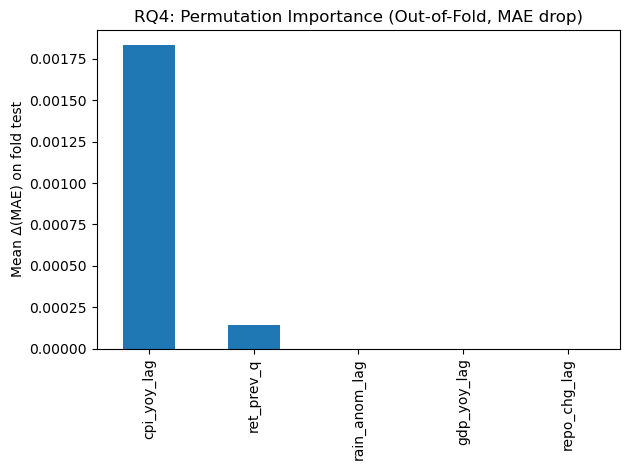

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error

# Safe display for notebooks/terminal
try:
    from IPython.display import display
except Exception:
    def display(x): print(x)

# Ensure PROC exists if this cell runs standalone
if "PROC" not in globals():
    PROC = Path("./processed"); PROC.mkdir(exist_ok=True)

# ---------- Build time-aware splits on the paired sample ----------
# Use the same aligned matrices from Cell 18
if "X_en_masked" not in globals() or "y_int" not in globals():
    raise RuntimeError("Expect X_en_masked and y_int from Cell 18 to be in scope.")

splits_pi = make_expanding_splits(len(y_int), min_train=24, test_size=2, step=1)
if len(splits_pi) == 0:
    raise ValueError("No CV splits produced. Reduce min_train/test_size or increase data length.")

# ---------- Fold-wise permutation importance (evaluated on test windows) ----------
all_means = []    # list of Series (per-fold importance means)
all_stds  = []    # list of Series (per-fold importance std)
all_cols  = X_en_masked.columns

for tr_pos, te_pos in splits_pi:
    # Convert positional indices to time index labels
    idx_tr = X_en_masked.index[tr_pos]
    idx_te = X_en_masked.index[te_pos]

    Xtr, ytr = X_en_masked.loc[idx_tr], y_int.loc[idx_tr]
    Xte, yte = X_en_masked.loc[idx_te], y_int.loc[idx_te]

    # Fit model on TRAIN window only
    mdl = make_lgbm()
    mdl.fit(Xtr, ytr)

    # Permutation importance on the TEST window (out-of-sample)
    # Scoring: use neg_mean_absolute_error for returns (robust to outliers).
    pi = permutation_importance(
        mdl, Xte, yte,
        scoring="neg_mean_absolute_error",
        n_repeats=200, random_state=42, n_jobs=-1
    )

    fold_mean = pd.Series(pi.importances_mean, index=all_cols)
    fold_std  = pd.Series(pi.importances_std,  index=all_cols)
    all_means.append(fold_mean)
    all_stds.append(fold_std)

# ---------- Aggregate across folds ----------
imp_mean = pd.concat(all_means, axis=1).mean(axis=1).rename("perm_importance_mean")
imp_std  = pd.concat(all_stds,  axis=1).mean(axis=1).rename("perm_importance_std")

# Higher is better (more drop in MAE when permuted).
# Sort descending for readability.
imp_df = pd.concat([imp_mean, imp_std], axis=1).sort_values("perm_importance_mean", ascending=False)

display(imp_df)

# Save results
out_path = PROC / "rq4_permutation_importance.csv"
imp_df.to_csv(out_path, index=True)
print("Saved:", out_path.resolve())

# ---------- Quick bar chart ----------
ax = imp_df["perm_importance_mean"].plot(
    kind="bar", title="RQ4: Permutation Importance (Out-of-Fold, MAE drop)"
)
ax.set_ylabel("Mean Δ(MAE) on fold test")
plt.tight_layout()
plt.show()

Add quick diagnostics plots

Goal: Visualize fit quality and residuals. First, a quick in-sample check (useful for sanity only). Then, a fold-safe out-of-fold (OOF) evaluation using your expanding-window CV — that’s the one to trust for performance.

Inputs: X_en, y, plus make_lgbm() and make_expanding_splits(...).

Outputs:

Two scatter plots (in-sample vs OOF) with a 45° line and summary metrics.

Residuals-over-time plots (in-sample and OOF).

Why: In-sample plots can look deceptively good; OOF predictions reflect true forecast behavior.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 4
[LightGBM] [Info] Start training from score 0.014469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


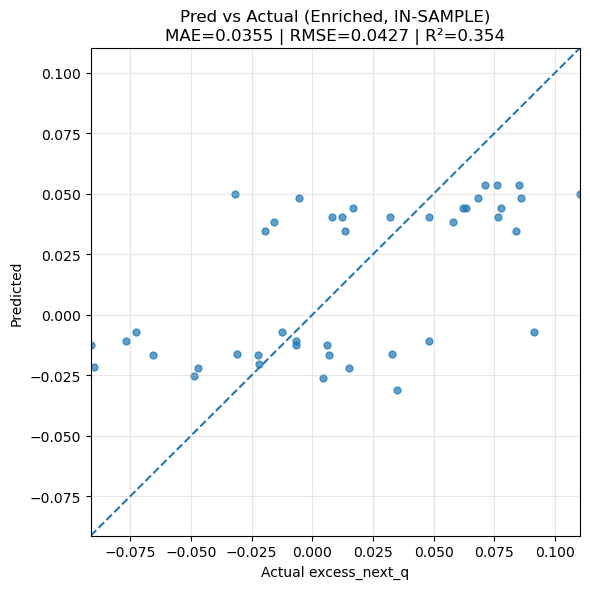

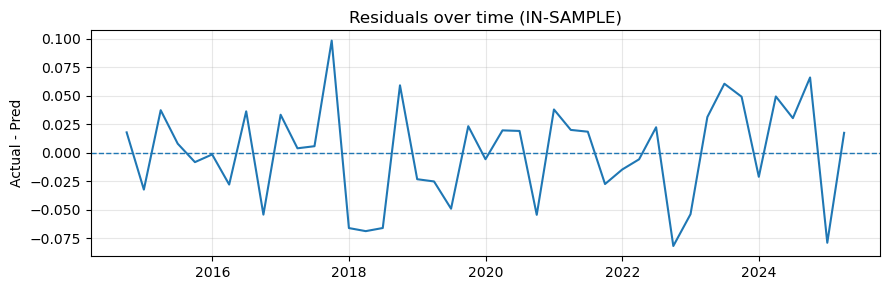

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 0.007365
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


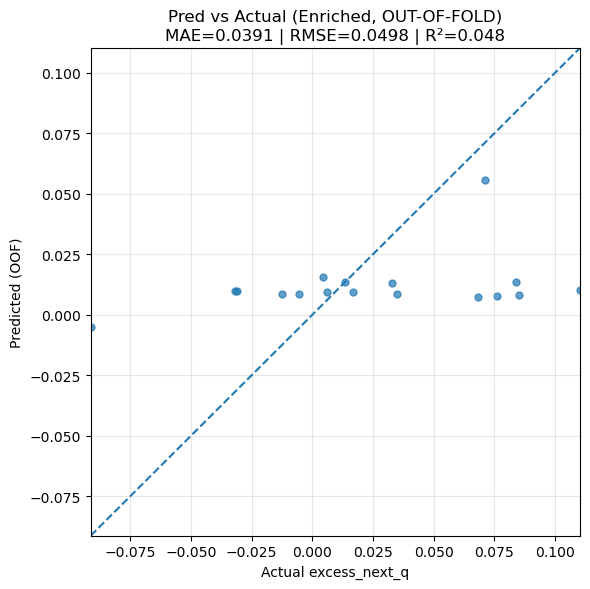

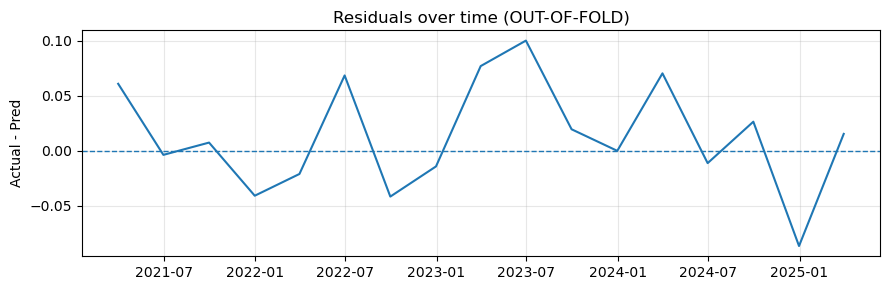

In [ ]:
# --- Safety: ensure chronological order
X_en = X_en.sort_index()
y    = y.sort_index()

# ---------- 1) Quick IN-SAMPLE diagnostic (fit on all data — NOT for evaluation) ----------
mdl_in = make_lgbm().fit(X_en, y)

# Make sure predictions are indexed like y (so later arithmetic aligns)
y_hat_in = pd.Series(mdl_in.predict(X_en), index=y.index, name="y_hat_in")

# Basic metrics (in-sample — optimistic)
mae_in  = mean_absolute_error(y, y_hat_in)
rmse_in = mean_squared_error(y, y_hat_in, squared=False)
r2_in   = r2_score(y, y_hat_in)

# Scatter: Actual vs Pred (in-sample)
plt.figure(figsize=(6,6))
plt.scatter(y, y_hat_in, s=25, alpha=0.7)
# 45° reference
lims = [float(min(y.min(), y_hat_in.min())), float(max(y.max(), y_hat_in.max()))]
plt.plot(lims, lims, linestyle="--")
plt.xlim(lims); plt.ylim(lims)
plt.title(f"Pred vs Actual (Enriched, IN-SAMPLE)\nMAE={mae_in:.4f} | RMSE={rmse_in:.4f} | R²={r2_in:.3f}")
plt.xlabel("Actual excess_next_q"); plt.ylabel("Predicted"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Residuals (in-sample)
res_in = (y - y_hat_in)
plt.figure(figsize=(9,3))
plt.plot(res_in.index, res_in.values)
plt.axhline(0, ls="--", lw=1)
plt.title("Residuals over time (IN-SAMPLE)")
plt.ylabel("Actual - Pred"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


# ---------- 2) OUT-OF-FOLD (OOF) predictions via expanding-window CV ----------
# Build splits on the current (paired) sample size
splits_oof = make_expanding_splits(len(y), min_train=24, test_size=2, step=1)
if len(splits_oof) == 0:
    raise ValueError("No CV splits. Reduce min_train/test_size or increase series length.")

# Collect OOF preds into a Series aligned to y's index
oof = pd.Series(index=y.index, dtype=float, name="oof_pred")

for tr_pos, te_pos in splits_oof:
    # Positional indices -> index labels
    idx_tr = X_en.index[tr_pos]
    idx_te = X_en.index[te_pos]

    Xtr, ytr = X_en.loc[idx_tr], y.loc[idx_tr]
    Xte, yte = X_en.loc[idx_te], y.loc[idx_te]

    mdl = make_lgbm()
    mdl.fit(Xtr, ytr)
    oof.loc[idx_te] = mdl.predict(Xte)

# Drop any untouched test positions (should be none if splits cover the tail)
oof = oof.dropna()
y_oof = y.loc[oof.index]

# Proper OOF metrics
mae_oof  = mean_absolute_error(y_oof, oof)
rmse_oof = mean_squared_error(y_oof, oof, squared=False)
r2_oof   = r2_score(y_oof, oof)

# Scatter: Actual vs Pred (OOF)
plt.figure(figsize=(6,6))
plt.scatter(y_oof, oof, s=25, alpha=0.7)
lims = [float(min(y_oof.min(), oof.min())), float(max(y_oof.max(), oof.max()))]
plt.plot(lims, lims, linestyle="--")
plt.xlim(lims); plt.ylim(lims)
plt.title(f"Pred vs Actual (Enriched, OUT-OF-FOLD)\nMAE={mae_oof:.4f} | RMSE={rmse_oof:.4f} | R²={r2_oof:.3f}")
plt.xlabel("Actual excess_next_q"); plt.ylabel("Predicted (OOF)"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Residuals (OOF)
res_oof = (y_oof - oof)
plt.figure(figsize=(9,3))
plt.plot(res_oof.index, res_oof.values)
plt.axhline(0, ls="--", lw=1)
plt.title("Residuals over time (OUT-OF-FOLD)")
plt.ylabel("Actual - Pred"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


Charting

Chart A — RQ1 bars (levels & deltas)

Goal: Read the RQ1 metrics table and plot (1) raw metric levels and (2) deltas vs baseline for the enriched model.

Plan: Load whichever file exists, normalize column names (DA → HitRate), and pick the “enriched” row by pattern. If Δ columns are missing, compute them.

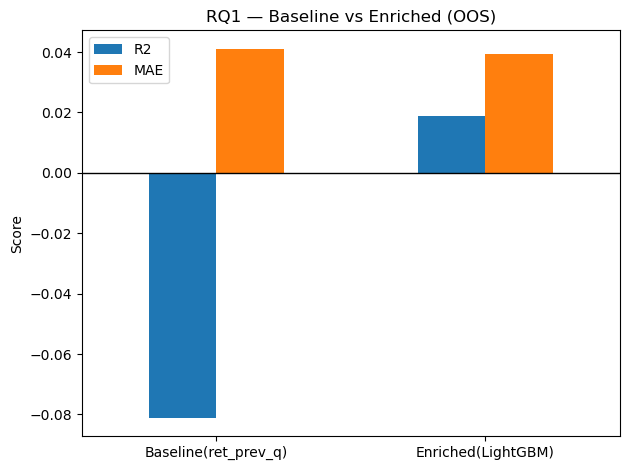

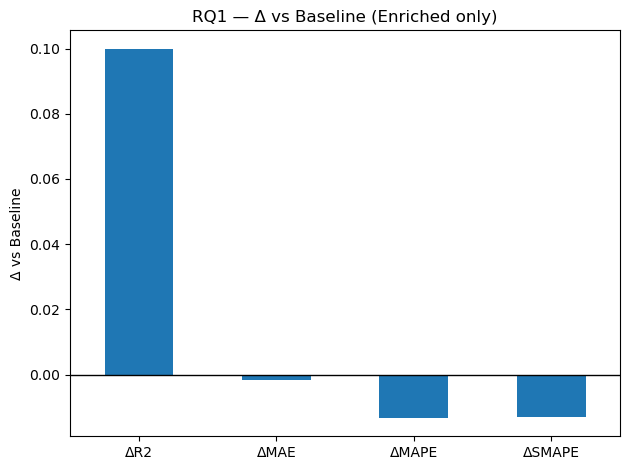

In [ ]:
# --- 1) Load whichever metrics file exists ---
candidates = [
    PROC / "rq1_metrics.csv",                         # produced in earlier cell
    PROC / "rq1_metrics_baseline_vs_enriched.csv"     # your original expectation
]
for path in candidates:
    if path.exists():
        rq1 = pd.read_csv(path, index_col=0)
        break
else:
    raise FileNotFoundError(
        "Could not find RQ1 metrics file. Looked for: "
        f"{candidates[0].name} and {candidates[1].name}"
    )

# --- 2) Normalize columns/index for plotting ---
# Use 'HitRate' in plots (alias for 'DA' = directional accuracy)
if "HitRate" not in rq1.columns and "DA" in rq1.columns:
    rq1 = rq1.rename(columns={"DA": "HitRate"})

# Some tables may not have Δ columns yet; we’ll add them if missing
has_delta_cols = any(c.startswith("Δ") for c in rq1.columns)

# Normalize enriched row name to a common label (for selection below)
# Keep original index for display, but also compute a selector robustly.
enriched_rows = [idx for idx in rq1.index if "enriched" in idx.lower()]
baseline_rows = [idx for idx in rq1.index if "baseline" in idx.lower()]
if not enriched_rows or not baseline_rows:
    # Fall back to last/first row if names differ
    enriched_rows = enriched_rows or [rq1.index[-1]]
    baseline_rows = baseline_rows or [rq1.index[0]]

enriched_label = enriched_rows[0]
baseline_label = baseline_rows[0]

# --- 3) If Δ columns missing, compute deltas vs baseline for numeric columns ---
if not has_delta_cols:
    num_cols = rq1.select_dtypes(include=["number"]).columns
    deltas = rq1[num_cols].subtract(rq1.loc[baseline_label, num_cols], axis="columns")
    deltas = deltas.rename(columns=lambda c: f"Δ{c}")
    rq1 = pd.concat([rq1, deltas], axis=1)

# --- 4) Plot LEVELS (R2, MAE, HitRate) if present ---
level_cols = [c for c in ["R2", "MAE", "HitRate"] if c in rq1.columns]
if not level_cols:
    raise KeyError("No level columns among ['R2','MAE','HitRate'] found in the metrics table.")

ax = rq1[level_cols].plot(kind='bar', rot=0, title='RQ1 — Baseline vs Enriched (OOS)')
ax.axhline(0, lw=1, color='black')
ax.set_ylabel("Score")
plt.tight_layout(); plt.show()

# --- 5) Plot DELTAS for the enriched model only ---
delta_cols = [c for c in rq1.columns if c.startswith('Δ')]
if len(delta_cols) == 0:
    raise KeyError("No Δ columns found or computed; cannot plot deltas.")

# Use the normalized enriched label, but display as 'Enriched(Model)' in the title
ax = rq1.loc[[enriched_label], delta_cols].T.plot(
    kind='bar', legend=False, rot=0,
    title='RQ1 — Δ vs Baseline (Enriched only)'
)
ax.axhline(0, lw=1, color='black')
ax.set_ylabel("Δ vs Baseline")
plt.tight_layout(); plt.show()


Chart B — RQ2 boxplot (Good vs Poor monsoon)

Goal: Recreate the good vs poor monsoon group arrays from disk or from qdf, using a clear sign convention and thresholds, and plot a boxplot.

Outputs: Group arrays good, poor, an optional CSV with stacked values, a simple Welch t-test readout, and a boxplot.

[info] rq2_monsoon_groups.csv not found — will recompute groups from qdf.

[groups] N_good=15, N_poor=20 | threshold=±4.0% | positive_is_good=True
[save] Wrote groups to C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq2_monsoon_groups.csv
[Welch t-test] Δmean(good - poor) = 0.0290 | p=0.09705


C:\Users\abpanick\AppData\Local\Temp\ipykernel_34548\4243589063.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([good, poor], labels=[lab_good, lab_poor], showmeans=True)


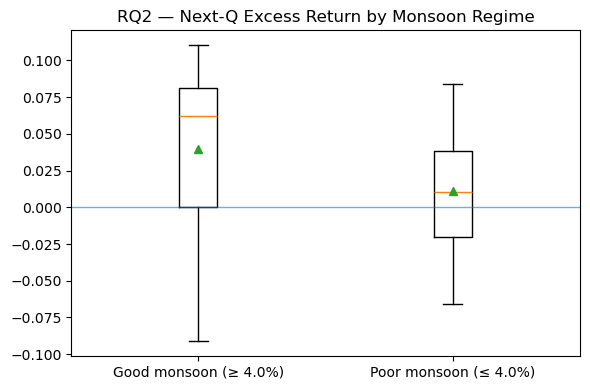

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_ind

PROC = Path("./processed")

# --- 1) Try to load precomputed groups/tests if present (optional) ---
path_groups = PROC / "rq2_monsoon_groups.csv"
path_tests  = PROC / "rq2_tests.txt"

if path_groups.exists():
    gfile = pd.read_csv(path_groups)
    print(f"[info] Loaded existing groups from {path_groups.name} (head):")
    print(gfile.head())
else:
    print(f"[info] {path_groups.name} not found — will recompute groups from qdf.")

if path_tests.exists():
    print(f"\n[info] Contents of {path_tests.name}:")
    with open(path_tests) as f:
        print(f.read())

# --- 2) Re-derive groups from qdf (standalone, no reliance on a prior 'mask') ---
# Load the clean quarterly features (prefer parquet; fallback to CSVs)
def _load_qdf():
    for p in [PROC/"quarterly_features.parquet",
              PROC/"quarterly_features_clean.csv",
              PROC/"quarterly_features.csv"]:
        if p.exists():
            try:
                return (pd.read_parquet(p) if p.suffix==".parquet" else pd.read_csv(p, index_col=0, parse_dates=True))
            except Exception:
                continue
    raise FileNotFoundError("quarterly_features(.parquet/.csv) not found in ./processed")

qdf_local = qdf if "qdf" in globals() else _load_qdf()
# Ensure DateTimeIndex
if not isinstance(qdf_local.index, pd.DatetimeIndex):
    # attempt to coerce first column to dates/quarters if needed
    try:
        qdf_local.index = pd.to_datetime(qdf_local.index)
    except Exception:
        pass

# Required columns
need = ["rain_anom_lag", "excess_next_q"]
missing = [c for c in need if c not in qdf_local.columns]
if missing:
    raise KeyError(f"Missing columns in qdf needed for RQ2: {missing}")

# Clean mask: both columns numeric, finite, non-null
qdf_use = qdf_local.copy()
for c in need:
    qdf_use[c] = pd.to_numeric(qdf_use[c], errors="coerce")
mask_clean = qdf_use[need].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)

# --- 3) Define regimes (CONFIGURABLE) ---
# With anomaly = (observed - normal)/normal * 100:
#   positive  -> above-normal rain (GOOD)
#   negative  -> below-normal rain (POOR)
positive_is_good = True  # set False if you *truly* want the opposite convention

thr = 4.0  # absolute anomaly threshold in percentage points (e.g., ±4%)

anom = qdf_use.loc[mask_clean, "rain_anom_lag"]

if positive_is_good:
    good_idx = anom >= +thr        # GOOD: >= +4%
    poor_idx = anom <= -thr        # POOR: <= -4%
else:
    good_idx = anom <= -thr        # (inverted convention)
    poor_idx = anom >= +thr

y_next = qdf_use.loc[mask_clean, "excess_next_q"]

good = y_next.loc[good_idx].dropna().to_numpy()
poor = y_next.loc[poor_idx].dropna().to_numpy()

print(f"\n[groups] N_good={len(good)}, N_poor={len(poor)} | threshold=±{thr}% | positive_is_good={positive_is_good}")

# --- 4) Optional: save stacked groups (one column 'label', one 'value') ---
if not path_groups.exists():
    stacked = pd.DataFrame({
        "label": (["good"]*len(good)) + (["poor"]*len(poor)),
        "value": np.concatenate([good, poor], axis=0)
    })
    stacked.to_csv(path_groups, index=False)
    print(f"[save] Wrote groups to {path_groups.resolve()}")

# --- 5) Simple Welch t-test (for quick sanity; KS or effect sizes can be added) ---
if len(good) >= 3 and len(poor) >= 3:
    tstat, pval = ttest_ind(good, poor, equal_var=False)
    print(f"[Welch t-test] Δmean(good - poor) = {good.mean() - poor.mean():.4f} | p={pval:.4g}")
else:
    print("[warn] Too few samples in one/both groups for a t-test (need ≥3 each).")

# --- 6) Boxplot (paired with counts in labels) ---
lab_good = f"Good monsoon ({'≥' if positive_is_good else '≤'} {thr}%)"
lab_poor = f"Poor monsoon ({'≤' if positive_is_good else '≥'} {thr}%)"

plt.figure(figsize=(6,4))
plt.boxplot([good, poor], labels=[lab_good, lab_poor], showmeans=True)
plt.title('RQ2 — Next-Q Excess Return by Monsoon Regime')
plt.axhline(0, lw=1, alpha=0.6)
plt.tight_layout(); plt.show()

Chart C — RQ4 permutation importance (horizontal bar)

Goal: Load the permutation-importance table saved earlier and plot a clean horizontal bar chart.

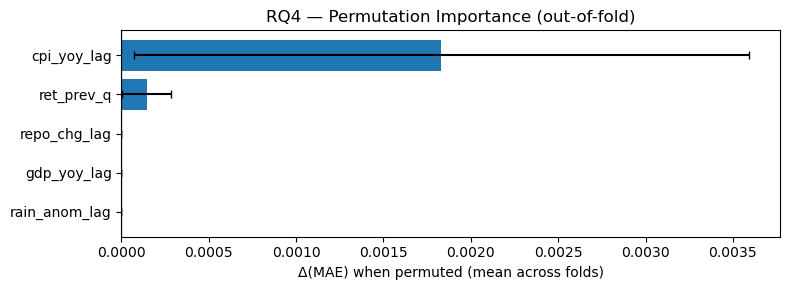

In [ ]:
# Load with the saved index (features) preserved, then materialize it as a column
pi = pd.read_csv(PROC/"rq4_permutation_importance.csv", index_col=0)

# Normalize possible column name variants
if "perm_importance_mean" not in pi.columns:
    # Older runs may have saved a single column named 'perm_importance'
    if "perm_importance" in pi.columns:
        pi = pi.rename(columns={"perm_importance": "perm_importance_mean"})
    else:
        raise KeyError("Expected 'perm_importance_mean' (or 'perm_importance') column not found.")

# If std isn’t present, create zeros so plotting with xerr is simple
if "perm_importance_std" not in pi.columns:
    pi["perm_importance_std"] = 0.0

# Move index to a column named 'feature'
pi = pi.reset_index().rename(columns={"index": "feature"})

# (Optional) limit to top-N features by importance
top_n = None  # e.g., 12
if top_n:
    pi = pi.nlargest(top_n, "perm_importance_mean")

# Sort so bars read nicely; flip to False if you want largest at top
pi = pi.sort_values("perm_importance_mean", ascending=True)

# Plot with error bars (std across folds)
plt.figure(figsize=(8, max(3, 0.35*len(pi))))
plt.barh(
    pi["feature"],
    pi["perm_importance_mean"],
    xerr=pi["perm_importance_std"].values if "perm_importance_std" in pi.columns else None,
    capsize=3
)
plt.xlabel("Δ(MAE) when permuted (mean across folds)")
plt.title("RQ4 — Permutation Importance (out-of-fold)")
plt.axvline(0, lw=1, color="black", alpha=0.5)
plt.tight_layout()
plt.show()

Pred vs Actual (enriched) — nice for RQ1 slide:

Goal: Load saved holdout predictions and plot Pred vs Actual without errors.

In [ ]:
path = PROC / "rq1_holdout_predictions.csv"

# 1) Load safely: make first column the index (dates), parse as datetime
#    (Fix: avoid referencing ho before assignment)
ho = pd.read_csv(path, index_col=0, parse_dates=True)

# 2) Auto-pick actual/pred columns (robust to naming)
def _pick(cols, candidates):
    cols_l = [c.lower() for c in cols]
    for key in candidates:
        for c, cl in zip(cols, cols_l):
            if key.lower() == cl or key.lower() in cl:
                return c
    return None

y_true_col = _pick(ho.columns, ["y_true","actual","target","excess_next_q"])
y_pred_col = _pick(ho.columns, ["y_pred_en","y_pred","yhat","pred","y_pred_enriched"])

if y_true_col is None or y_pred_col is None:
    raise KeyError(f"Could not find actual/pred columns. Columns present: {list(ho.columns)}")

# 3) Clean / align
y_true = pd.to_numeric(ho[y_true_col], errors="coerce")
y_pred = pd.to_numeric(ho[y_pred_col], errors="coerce")
mask   = y_true.notna() & y_pred.notna()
y_true, y_pred = y_true[mask], y_pred[mask]

# 4) Metrics
mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2   = r2_score(y_true, y_pred)

# 5) Scatter with a 45° line (use plt.plot for broad compatibility)
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=25, alpha=0.75)
lims = [float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))]
plt.plot(lims, lims, linestyle="--", color="black", linewidth=1)
plt.xlim(lims); plt.ylim(lims)
plt.title(f"RQ1 Holdout — Pred vs Actual (Enriched)\nMAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.3f}")
plt.xlabel("Actual excess_next_q"); plt.ylabel("Predicted")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 6) Residuals over time (optional but handy)
res = (y_true - y_pred)
plt.figure(figsize=(9,3))
plt.plot(res.index, res.values)
plt.axhline(0, ls="--", lw=1, color="black")
plt.title("RQ1 Holdout — Residuals over time (Enriched)")
plt.ylabel("Actual - Pred")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'processed\\rq1_holdout_predictions.csv'